In [1]:
import yfinance
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = yfinance.download("USDBRL=X", start="2020-01-01", end="2025-07-13", interval="1d")

C:\Users\mateu\AppData\Local\Temp\ipykernel_19176\1133883838.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yfinance.download("USDBRL=X", start="2020-01-01", end="2025-07-13", interval="1d")
[*********************100%***********************]  1 of 1 completed


In [3]:
data = data['Close']

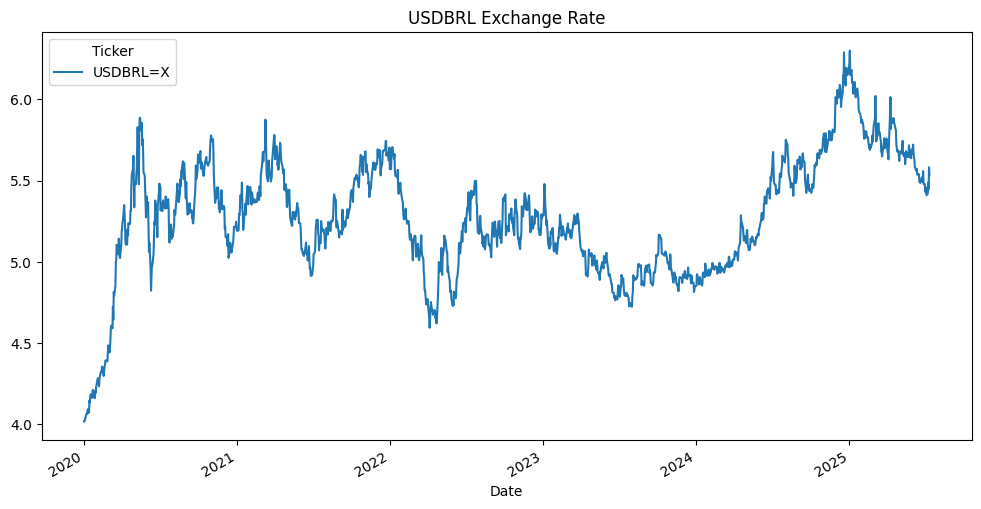

In [4]:
data.plot(figsize=(12, 6))
plt.title("USDBRL Exchange Rate")
plt.xlabel("Date")
plt.show()

In [5]:
data['mean'] = data['USDBRL=X'].rolling(window=50).mean()

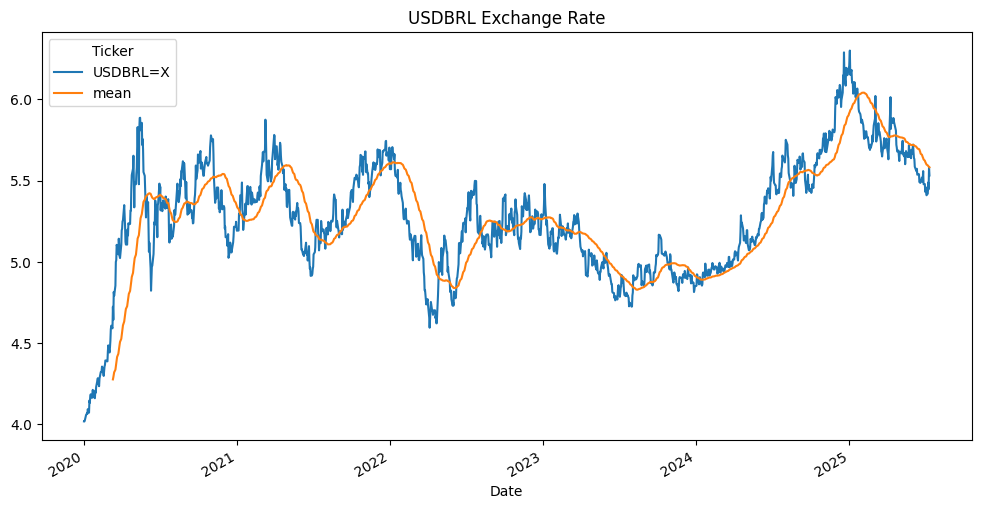

In [6]:
data.plot(figsize=(12, 6))
plt.title("USDBRL Exchange Rate")
plt.xlabel("Date")
plt.show()

In [7]:
# verificar se a serie é estacionária
from statsmodels.tsa.stattools import adfuller
result = adfuller(data['USDBRL=X'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] < 0.05:
    print("A série é estacionária")
else:
    print("A série não é estacionária")

ADF Statistic: -3.758229173681506
p-value: 0.0033647937357304423
A série é estacionária


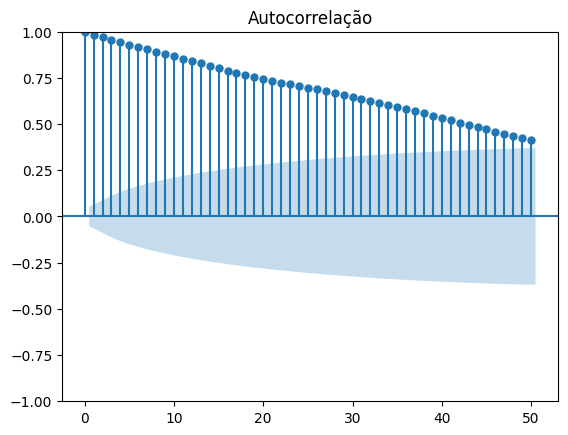

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['USDBRL=X'], lags=50)
plt.title("Autocorrelação")
plt.show()

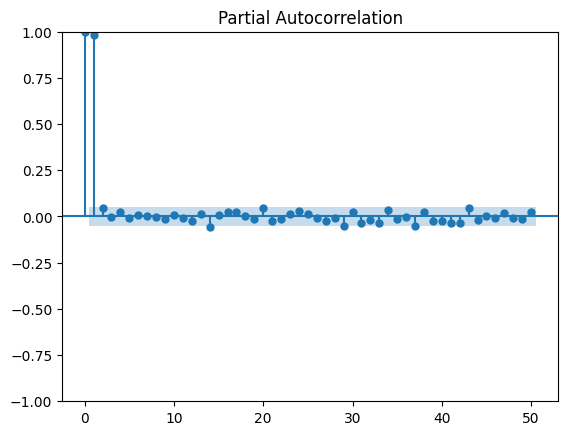

In [9]:
plot_pacf(data['USDBRL=X'], lags=50)
plt.show()

In [10]:
from statsmodels.tsa.stattools import kpss
kpss_result = kpss(data['USDBRL=X'])
print('KPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])

if kpss_result[1] < 0.05:
    print("A série é estacionária")
else:
    print("A série não é estacionária")

KPSS Statistic: 0.7197058209382887
p-value: 0.011754016278337389
A série é estacionária


In [11]:
data['diff'] = data['USDBRL=X'].diff().apply(lambda x: 0 if pd.isna(x) else x)

<Axes: xlabel='Date'>

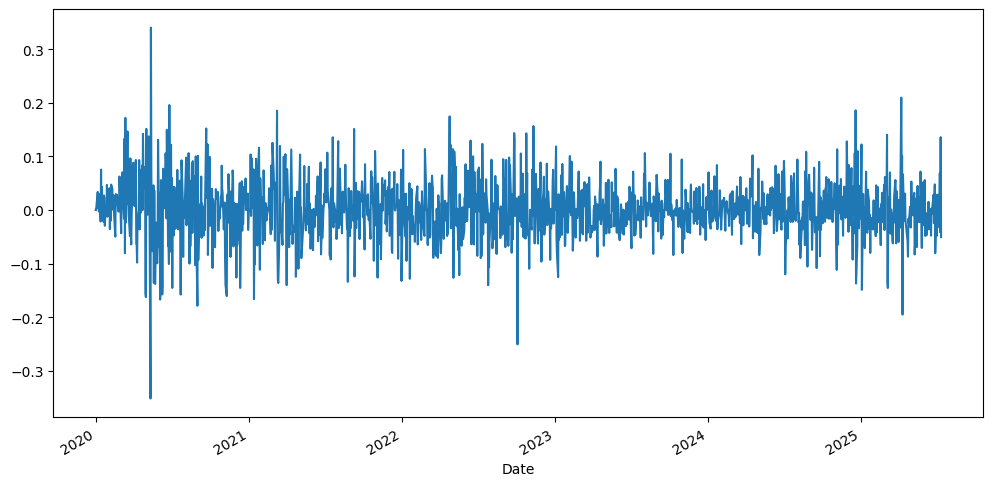

In [12]:
data['diff'].plot(figsize=(12, 6))

## Example 1

In [13]:
# timesgeneretor tensoflow
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

In [14]:
series = data['USDBRL=X'].values

In [15]:
series = MinMaxScaler().fit_transform(series.reshape(-1, 1))

In [16]:
train_index = int(len(series) * 0.8)


# Split the data into training and testing sets
train = series[:train_index]
test  = series[train_index:]


# Create Timeseries Generators
train_generator = TimeseriesGenerator(
    train, train, length=50, batch_size=32
)
test_generator = TimeseriesGenerator(
    test, test, length=50, batch_size=32
)

In [67]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(50, input_shape=[None, 1], return_sequences=True),
    keras.layers.SimpleRNN(50, input_shape=[None, 1], return_sequences=True),
    keras.layers.SimpleRNN(50, input_shape=[None, 1], return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1)),
])

c:\Users\mateu\Documents\Norton\Projetos GIT\livro-aprendizado-de-maquina-sklearn-keras-tf\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [68]:
lr = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=10000, decay_rate=0.9)


model.compile(
    loss=keras.losses.mean_squared_error,
    optimizer=keras.optimizers.Adam(learning_rate=lr),
    metrics=[keras.metrics.mean_absolute_error]
)

In [69]:
model.fit(
    train_generator,
    epochs=20,
    callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=3)],
)

Epoch 1/20


35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.3033 - mean_absolute_error: 0.3798
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0574 - mean_absolute_error: 0.1965
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0170 - mean_absolute_error: 0.1033
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0293 - mean_absolute_error: 0.1375
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0202 - mean_absolute_error: 0.1136
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0220 - mean_absolute_error: 0.1190


In [70]:
predicoes_completas = []

# Predições no treino
janela_tempo = 50

entrada_atual = series[:50]


for i in range(len(series) - 50):
    pred = model.predict(entrada_atual.reshape(1, janela_tempo, 1), verbose=0)
    predicoes_completas.append(pred[0, 0])
    entrada_atual = np.append(entrada_atual[1:], series[i + janela_tempo])

In [71]:
entrada_atual = series[-janela_tempo:]

predicoes_futuro = []
for _ in range(10):
    pred = model.predict(entrada_atual.reshape(1, janela_tempo, 1), verbose=0)
    predicoes_futuro.append(pred[0, 0])
    
    entrada_atual = np.append(entrada_atual[1:], pred[0, 0])
    entrada_atual = entrada_atual[-janela_tempo:]

In [72]:
len(predicoes_completas), len(series)

(1390, 1440)

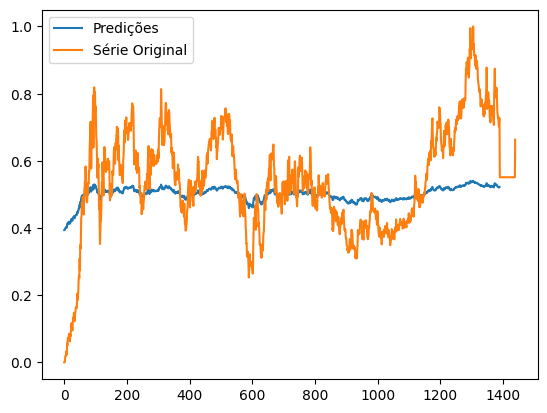

In [73]:
plt.plot(predicoes_completas, label='Predições')
plt.plot(series, label='Série Original')
plt.legend()
plt.show()